In [1]:
import numpy as np, copy
import matplotlib.pyplot as plt
%matplotlib inline
from astropy import constants as const
import astropy.units as u
from astropy.units import cds
cds.enable()

In [2]:
def read_model(file):
    cols=np.array([1,2,3,4,5,29,66])-1
    return np.genfromtxt(file, skip_header=5, names=True, usecols=cols)

In [3]:
def Lane_zp(x, y, z, n):
    if y<0:
        y=0
    return -2.0 * z / x - y**n

def poly_num(n, h=0.01, x_end=16.0, xinit=0.00001):
    #The step and the ending eps value is initialized
    #n: polytrope index
    #h: 0.05 step size
    #x_end: 16.0
    
    #The starting value was initialized
    
    x = xinit
    y= 1 - ( 1.0/6.0 * x**2) + ( n/120.0 * x**4 ) - ( n*(8*n-5)/15120.0 * x**6 )
    z=- ( 1.0/6.0 * 2 * x ) + ( n/120.0 * 4 * x**3 ) - (n*(8*n-5)/15120.0 * 6 * x**5)
    zp=-( 1.0/6.0 * 2 ) + ( n/120.0 * 12 * x**2 ) - ( n*(8*n-5)/15120.0 * 6*5 * x**4)
    
    eps=np.array([h])
    theta=np.array([y])
    theta_prim = np.array([z])
    
    #Make the calculation until we reach x_end, or theta goes to zero
    while (x<x_end) and (y>0):
        K1 = h * z
        L1 = h * Lane_zp(x, y, z, n)
        K2 = h * (z + L1/2.0)
        L2 = h * Lane_zp(x+h/2.0, y+K1/2.0, z+L1/2.0, n)
        K3 = h * (z + L2/2.0)
        L3 = h * Lane_zp(x+h/2.0, y+K2/2.0, z+L2/2.0, n)
        K4 = h * (z + L3/2.0)
        L4 = h * Lane_zp(x+h, y+K3, z+L3, n)

        y = y + K1/6.0 + K2/3.0 + K3/3.0 + K4/6.0
        z = z + L1/6.0 + L2/3.0 + L3/3.0 + L4/6.0

        x = x + h

        eps = np.append(eps,x)
        theta = np.append(theta, y)
        theta_prim = np.append(theta_prim, z)
#         print("eps=",eps,"theta=",theta,"theta_prim=",theta_prim)
    
    return eps[0:eps.size-1], theta[0:theta.size-1], theta_prim[0:theta_prim.size-1]

In [4]:
def poly_n0(eps):
    #eps is an array of epsilon values
    return 1.0 - eps**2

def poly_n1(eps):
    return np.sin(eps)/eps

def poly_n5(eps):
    return (1.0 + eps**2.0/3.0)**(-0.5)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


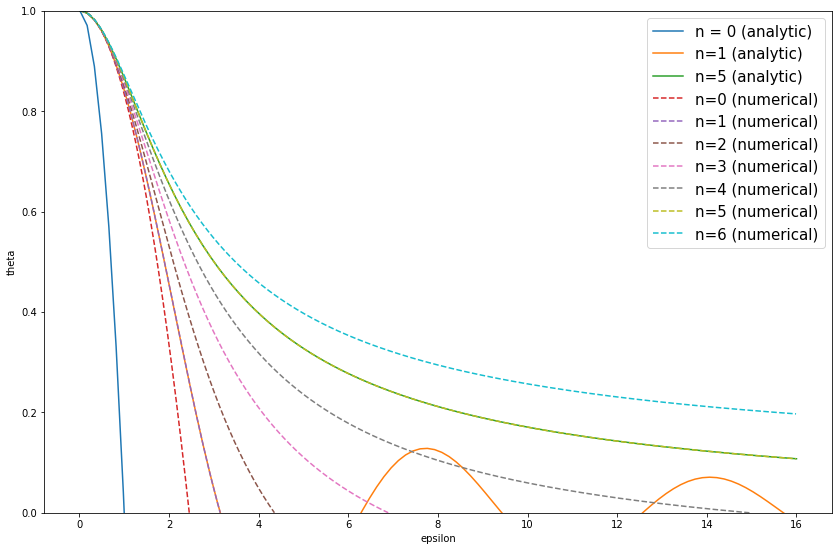

In [5]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plt.rcParams.update({'font.size':18})
plt.rcParams.update({'font.family':'Times New Roman'})

ax.set_ylim(0,1)

#Analytic solutions

#Define a set of eps values
eps = np.linspace(0.01,16,100)

ax.plot(eps,poly_n0(eps),label='n = 0 (analytic)')
ax.plot(eps,poly_n1(eps),label='n=1 (analytic)')
ax.plot(eps,poly_n5(eps),label='n=5 (analytic)')
plt.xlabel("epsilon")
plt.ylabel("theta")

#Numerical solutions
#the function poly_num(n) will return
#an array of eps_values, an array of dTheta/dEps at Eps1.

n=[0,1,2,3,4,5,6]

for item in n:
    eps, theta, theta_p = poly_num(item)
    str1=('n=%d (numerical)')%item
    ax.plot(eps, theta,ls='--',label=str1)

ax.legend(loc=0, fontsize=15)
plt.tight_layout()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


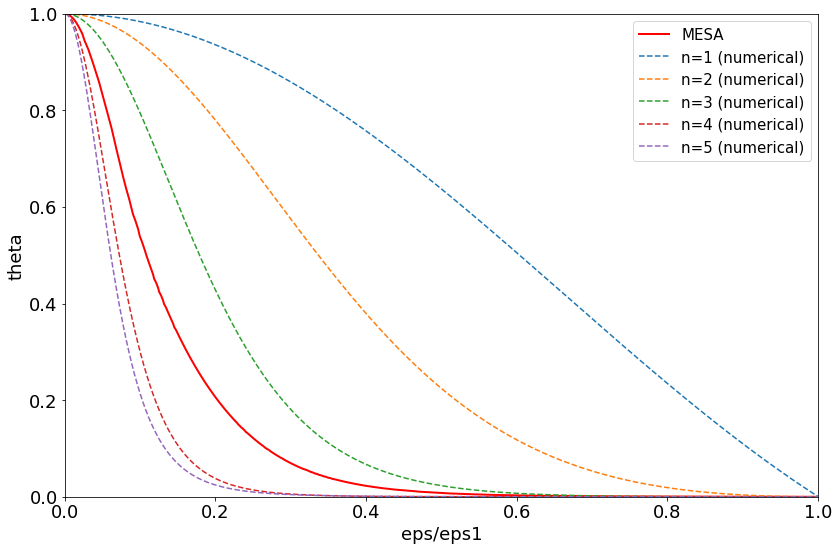

In [6]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plt.rcParams.update({'font.size':18})
plt.rcParams.update({'font.family':'Times New Roman'})

ax.set_xlim(0,1)
ax.set_ylim(0,1)

#MESA solar model
mesa = read_model('04-MESAdatafile.txt')

#In the mesa model, the first element [0] correspond to the surface,
#and the last element [mesa.size-1] correspond to the center.

mesa_r = 10**(mesa['logR']-mesa['logR'][0])
mesa_rho = 10**(mesa['logRho']-mesa['logRho'][mesa.size-1]) #the density is given in cgs
ax.plot(mesa_r, mesa_rho, c="red", lw=2, label='MESA')

#numerical solutions 
n=[1,2,3,4,5]
for item in n:
    eps, theta, theta_prim = poly_num(item)
    eps1 = eps[eps.size-1]
    str1=('n=%d (numerical)')%item
    ax.plot(eps/eps1, theta**item,ls='--',label=str1)
    
plt.xlabel('eps/eps1')
plt.ylabel('theta')

ax.legend(loc=0, fontsize=15)
plt.tight_layout()

n 	 theta1 	 	 central density

0.5 	 5.486691161565843 	 2.5783421672606495 g / cm3
1 	 9.850794152624788 	 4.629150283258992 g / cm3
1.5 	 17.91319170234899 	 8.417885416974862 g / cm3
2 	 34.13850482167113 	 16.042591776539048 g / cm3
2.5 	 70.0191621860149 	 32.90386738825341 g / cm3
2.75 	 104.5800734795651 	 49.144959205363136 g / cm3
3 	 162.10129227712173 	 76.17571044882119 g / cm3
3.5 	 456.5361829415333 	 214.53849992578105 g / cm3
4 	 1860.0532363406783 	 874.0885082436688 g / cm3

Mean density is 0.238732414637843 solMass / solRad3 
In cgs units 1.4097798243075257 g / cm3
theta1 is the degree of central concentration


Text(0, 0.5, 'Mean density in g/cm3')

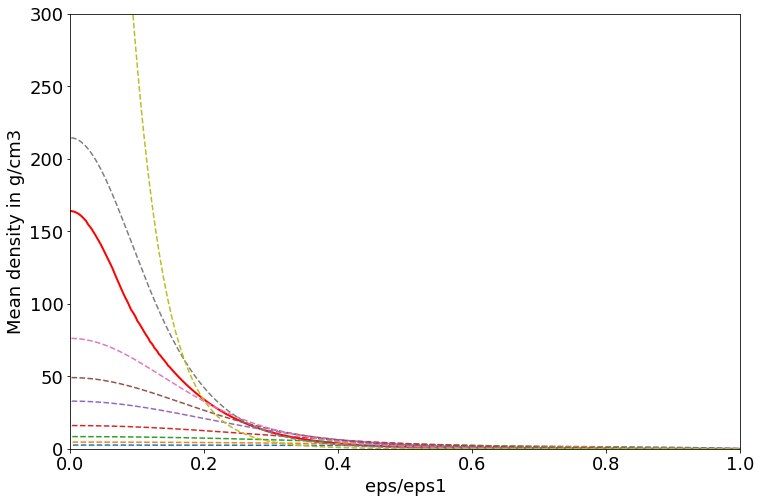

In [7]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plt.rcParams.update({'font.size':18})
plt.rcParams.update({'font.family':'Times New Roman'})

ax.set_xlim(0,1)
ax.set_ylim(0,300)

#MESA solar model
mesa = read_model('04-MESAdatafile.txt')

#In the mesa model, the first element [0] correspond to the surface,
#and the last element [mesa.size-1] correspond to the center.

mesa_r = 10**(mesa['logR']-mesa['logR'][0])
mesa_rho = 10**(mesa['logRho']) #the density is given in cgs
ax.plot(mesa_r, mesa_rho, c="red", lw=2, label='MESA')

print ("n",'\t','theta1','\t','\t','central density\n')

n=[0.5,1,1.5,2,2.5,2.75,3,3.5,4]

for item in n:
    eps, theta, theta_prim = poly_num(item)
    eps1 = eps[eps.size-1]
    theta1 = -eps1/theta_prim[eps.size-1]
    rho_c = 0.25 * theta1 * u.Msun / np.pi / u.Rsun**3
    print(item, '\t',theta1, '\t', rho_c.cgs)
    str1=('n=%d (numerical)')%item
    ax.plot(eps/eps1, rho_c.cgs*theta**item,ls='--',label=str1)
rho_mn = 0.75 * u.Msun / np.pi / u.Rsun**3
print('\nMean density is', rho_mn, "\nIn cgs units", rho_mn.cgs)
print('theta1 is the degree of central concentration')
plt.xlabel('eps/eps1')
plt.ylabel('Mean density in g/cm3')